## Survival Models :- COX , PenalizedCOX , Random Forest Surviavl

In [1]:
import pandas as pd
import numpy as np, warnings
from pathlib import Path
import os
import sweetviz as sv
from importlib import reload

np.warnings = warnings



In [2]:
# import utility functions
import src.utils as utils

# Note: to run main notebook from root directory, use:
ROOT_DIR = Path('')
# setup OS agnostic pathnames
# ROOT_DIR = Path('..')

import src.DataLoader as DataLoader
reload(DataLoader)

dataLoader = DataLoader.DataLoader(ROOT_DIR)

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate, cross_val_score, RandomizedSearchCV

%matplotlib inline
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
from sklearn import set_config
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest
from sklearn.utils.class_weight import compute_sample_weight

from src.utils import filter_missing_rows

from sklearn.preprocessing import StandardScaler

from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis

from src.utils import filter_missing_rows
import joblib

import src.engineer_features as ef

#### 1.1 Data Cleaning

In [4]:
df_desc_icd, df_desc_labitems, df_desc_items = dataLoader.load_descriptions()
df_diagnoses_icd = dataLoader.load_diagnoses_icd(df_desc_icd)
df_demographic = dataLoader.load_demographic(df_diagnoses_icd)

Removed 8210 admissions with AGE < 18


In [5]:
count_over100 = len(df_demographic[df_demographic.AGE>100])
p_over100 = len(df_demographic[df_demographic.AGE>100])/len(df_demographic)*100
median_age = int(df_demographic['AGE'].median())
print('The number of admissions aged over 100 years old is: {} admissions ({:.2f}% over all admissions)'.format(count_over100, p_over100))
print('The median age of patients: {}'.format(median_age))
df_demographic = dataLoader.demographic_clean_AGE(df_demographic)

The number of admissions aged over 100 years old is: 2616 admissions (5.15% over all admissions)
The median age of patients: 65


In [6]:
df_labevents = dataLoader.load_labevents(df_demographic)
df_labevents = dataLoader.labevents_compute_TIME(df_labevents, df_demographic)

##### 1.2 Data Exploration

In [7]:
df_demographic[df_demographic['IS_SEPSIS'] == 1]["DEATHTIME"].isna().value_counts()

DEATHTIME
True     3581
False    1595
Name: count, dtype: int64

#### Data Loader

In [8]:
#dataLoader.create_train_data(df_labevents, df_demographic, df_desc_labitems, hours=0, feature_no=20)
#dataLoader.create_train_data(df_labevents, df_demographic, df_desc_labitems, hours=2, feature_no=20)
#dataLoader.create_train_data(df_labevents, df_demographic, df_desc_labitems, hours=6, feature_no=40)

## 2.1 Survival Analysis

In [9]:
# final data frame
#df_final = dataLoader.extract_train_data_by_features(df_labevents, df_demographic,df_desc_labitems, 4,ROOT_DIR/'data/potential_labevents_count_with_proportion.csv', 30)

In [10]:
path_t4_df = ROOT_DIR / 'data' / 'Model input data'/"t6.csv"  
t4 = pd.read_csv(path_t4_df)

In [11]:
t4

,SUBJECT_ID,HADM_ID,AGE,GENDER_NUM,IS_SEPSIS,ITEMID_50804,ITEMID_50809,ITEMID_50813,ITEMID_50818,ITEMID_50820,...,ITEMID_51249,ITEMID_51250,ITEMID_51256,ITEMID_51265,ITEMID_51274,ITEMID_51275,ITEMID_51277,ITEMID_51279,ITEMID_51301,ITEMID_51493
0,3,145834,76,0,0,15.0,267.0,5.0,33.0,7.26,...,32.2,92.0,81.0,253.0,15.6,46.4,15.3,2.79,19.1,-999.0
1,4,185777,47,1,0,-999.0,-999.0,-999.0,-999.0,-999.00,...,33.8,90.0,89.6,207.0,12.3,31.3,13.6,3.80,9.7,-999.0
2,6,107064,65,1,0,19.0,145.0,3.0,41.0,7.25,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.00,-999.0,-999.0
3,9,150750,41,0,0,-999.0,-999.0,-999.0,-999.0,-999.00,...,34.1,83.0,50.1,258.0,12.7,21.7,13.4,5.46,7.5,0.0
4,11,194540,50,1,0,-999.0,-999.0,-999.0,-999.0,-999.00,...,33.8,86.0,91.4,229.0,13.0,28.3,13.4,4.31,8.5,-999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47596,99983,117390,78,0,0,-999.0,-999.0,-999.0,-999.0,-999.00,...,34.9,92.0,-999.0,253.0,13.4,27.0,12.7,4.21,7.5,-999.0
47597,99985,176670,53,0,1,-999.0,-999.0,-999.0,-999.0,-999.00,...,34.2,87.0,85.1,349.0,-999.0,-999.0,14.0,4.20,13.0,-999.0
47598,99992,197084,65,1,0,-999.0,-999.0,-999.0,-999.0,-999.00,...,36.4,95.0,84.9,188.0,12.9,43.9,16.3,1.35,21.4,-999.0
47599,99995,137810,88,1,0,34.0,110.0,1.3,44.0,7.49,...,-999.0,-999.0,-999.0,-999.0,19.7,35.5,-999.0,-999.00,-999.0,-999.0


In [12]:
df_demographic['last_seen'] = df_demographic['DEATHTIME'].fillna(df_demographic['DISCHTIME'])
df_demographic['last_seen'] =  pd.to_datetime(df_demographic['last_seen'], format='%Y-%m-%d %H:%M:%S')
df_demographic["total_stay"]  = (df_demographic["last_seen"] - df_demographic["ADMITTIME"]).dt.total_seconds() / 3600
df_demographic["total_stay"] = df_demographic["total_stay"].round()
df_demographic["status"] = df_demographic["DEATHTIME"].notna()

In [13]:
#dropping the rows which have negative total stay i.e. discharge time less than admit time
df_demographic = df_demographic[df_demographic["total_stay"] >= 0]

In [14]:
df_demographic

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,HAS_CHARTEVENTS_DATA,GENDER,DOB,EXPIRE_FLAG,AGE,IS_SEPSIS,AGE_cat,last_seen,total_stay,status
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,...,1,F,2131-05-07,0,64,0,51-70,2196-04-10 15:54:00,27.0,False
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,1,M,2082-07-17,0,71,0,71+,2153-09-08 19:10:00,132.0,False
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,...,1,M,2082-07-17,0,75,0,71+,2157-10-25 14:00:00,162.0,False
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,...,1,M,2100-05-31,0,39,0,36-50,2139-06-09 12:48:00,69.0,False
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,...,1,M,2101-11-21,0,58,0,51-70,2160-11-05 14:55:00,85.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50761,58592,98794,190603,2127-11-07 11:00:00,2127-11-11 14:30:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,1,M,2049-07-29,0,78,0,71+,2127-11-11 14:30:00,100.0,False
50762,58593,98797,105447,2132-12-24 20:06:00,2132-12-25 12:00:00,2132-12-25 12:00:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,...,1,M,2044-12-27,1,88,1,71+,2132-12-25 12:00:00,16.0,True
50763,58594,98800,191113,2131-03-30 21:13:00,2131-04-02 15:02:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Private,...,1,F,2111-11-05,0,19,0,18-35,2131-04-02 15:02:00,66.0,False
50764,58595,98802,101071,2151-03-05 20:00:00,2151-03-06 09:10:00,2151-03-06 09:10:00,EMERGENCY,CLINIC REFERRAL/PREMATURE,DEAD/EXPIRED,Medicare,...,1,F,2067-09-21,1,83,0,71+,2151-03-06 09:10:00,13.0,True


In [67]:
df_required = pd.merge(t4, df_demographic[["SUBJECT_ID","HADM_ID","total_stay","status"]] , on=["SUBJECT_ID","HADM_ID"], how = 'inner')



In [68]:
df_required

,SUBJECT_ID,HADM_ID,AGE,GENDER_NUM,IS_SEPSIS,ITEMID_50804,ITEMID_50809,ITEMID_50813,ITEMID_50818,ITEMID_50820,...,ITEMID_51256,ITEMID_51265,ITEMID_51274,ITEMID_51275,ITEMID_51277,ITEMID_51279,ITEMID_51301,ITEMID_51493,total_stay,status
0,3,145834,76,0,0,15.0,267.0,5.0,33.0,7.26,...,81.0,253.0,15.6,46.4,15.3,2.79,19.1,-999.0,259.0,False
1,4,185777,47,1,0,-999.0,-999.0,-999.0,-999.0,-999.00,...,89.6,207.0,12.3,31.3,13.6,3.80,9.7,-999.0,186.0,False
2,6,107064,65,1,0,19.0,145.0,3.0,41.0,7.25,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.00,-999.0,-999.0,393.0,False
3,9,150750,41,0,0,-999.0,-999.0,-999.0,-999.0,-999.00,...,50.1,258.0,12.7,21.7,13.4,5.46,7.5,0.0,117.0,True
4,11,194540,50,1,0,-999.0,-999.0,-999.0,-999.0,-999.00,...,91.4,229.0,13.0,28.3,13.4,4.31,8.5,-999.0,613.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47515,99983,117390,78,0,0,-999.0,-999.0,-999.0,-999.0,-999.00,...,-999.0,253.0,13.4,27.0,12.7,4.21,7.5,-999.0,74.0,False
47516,99985,176670,53,0,1,-999.0,-999.0,-999.0,-999.0,-999.00,...,85.1,349.0,-999.0,-999.0,14.0,4.20,13.0,-999.0,398.0,False
47517,99992,197084,65,1,0,-999.0,-999.0,-999.0,-999.0,-999.00,...,84.9,188.0,12.9,43.9,16.3,1.35,21.4,-999.0,72.0,False
47518,99995,137810,88,1,0,34.0,110.0,1.3,44.0,7.49,...,-999.0,-999.0,19.7,35.5,-999.0,-999.00,-999.0,-999.0,77.0,False


In [69]:
df_required['sofa_score'] = ef.get_sofa_score(df=df_required)

In [70]:
df_required

,SUBJECT_ID,HADM_ID,AGE,GENDER_NUM,IS_SEPSIS,ITEMID_50804,ITEMID_50809,ITEMID_50813,ITEMID_50818,ITEMID_50820,...,ITEMID_51265,ITEMID_51274,ITEMID_51275,ITEMID_51277,ITEMID_51279,ITEMID_51301,ITEMID_51493,total_stay,status,sofa_score
0,3,145834,76,0,0,15.0,267.0,5.0,33.0,7.26,...,253.0,15.6,46.4,15.3,2.79,19.1,-999.0,259.0,False,4
1,4,185777,47,1,0,-999.0,-999.0,-999.0,-999.0,-999.00,...,207.0,12.3,31.3,13.6,3.80,9.7,-999.0,186.0,False,4
2,6,107064,65,1,0,19.0,145.0,3.0,41.0,7.25,...,-999.0,-999.0,-999.0,-999.0,-999.00,-999.0,-999.0,393.0,False,-999
3,9,150750,41,0,0,-999.0,-999.0,-999.0,-999.0,-999.00,...,258.0,12.7,21.7,13.4,5.46,7.5,0.0,117.0,True,-999
4,11,194540,50,1,0,-999.0,-999.0,-999.0,-999.0,-999.00,...,229.0,13.0,28.3,13.4,4.31,8.5,-999.0,613.0,False,-999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47515,99983,117390,78,0,0,-999.0,-999.0,-999.0,-999.0,-999.00,...,253.0,13.4,27.0,12.7,4.21,7.5,-999.0,74.0,False,-999
47516,99985,176670,53,0,1,-999.0,-999.0,-999.0,-999.0,-999.00,...,349.0,-999.0,-999.0,14.0,4.20,13.0,-999.0,398.0,False,-999
47517,99992,197084,65,1,0,-999.0,-999.0,-999.0,-999.0,-999.00,...,188.0,12.9,43.9,16.3,1.35,21.4,-999.0,72.0,False,4
47518,99995,137810,88,1,0,34.0,110.0,1.3,44.0,7.49,...,-999.0,19.7,35.5,-999.0,-999.00,-999.0,-999.0,77.0,False,-999


In [71]:
# dropping the patients who have sepsis but not died untill discharge

df_required = df_required.drop(df_required[(df_required['IS_SEPSIS']==1) & (df_required['status']==False)].index)


In [72]:
df_required[(df_required["IS_SEPSIS"]==0) & (df_required["total_stay"] < 100) & (df_required["status"]==True)]

,SUBJECT_ID,HADM_ID,AGE,GENDER_NUM,IS_SEPSIS,ITEMID_50804,ITEMID_50809,ITEMID_50813,ITEMID_50818,ITEMID_50820,...,ITEMID_51265,ITEMID_51274,ITEMID_51275,ITEMID_51277,ITEMID_51279,ITEMID_51301,ITEMID_51493,total_stay,status,sofa_score
48,67,155252,73,0,0,-999.0,-999.0,-999.0,-999.0,-999.00,...,183.0,13.2,35.5,13.6,5.70,9.3,-999.0,3.0,True,-999
61,84,166401,44,1,0,-999.0,-999.0,-999.0,-999.0,-999.00,...,262.0,-999.0,-999.0,13.8,4.09,7.1,0.0,82.0,True,2
77,103,133550,60,1,0,-999.0,-999.0,-999.0,-999.0,-999.00,...,-999.0,13.0,23.4,-999.0,-999.00,-999.0,-999.0,39.0,True,-999
115,109,189332,25,1,0,-999.0,95.0,1.1,-999.0,-999.00,...,93.0,14.1,37.9,18.0,2.73,4.3,-999.0,44.0,True,-999
145,141,168006,80,0,0,12.0,-999.0,15.3,25.0,7.27,...,150.0,16.8,35.8,13.0,3.83,15.6,-999.0,81.0,True,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47400,99553,164310,85,1,0,18.0,167.0,6.8,45.0,7.20,...,-999.0,-999.0,-999.0,-999.0,-999.00,-999.0,-999.0,8.0,True,-999
47404,99556,196292,83,1,0,23.0,-999.0,7.7,43.0,7.32,...,407.0,11.6,24.5,18.8,2.60,9.8,1.0,25.0,True,1
47452,99768,140641,60,0,0,21.0,-999.0,1.8,24.0,7.54,...,116.0,19.0,34.1,19.6,2.53,16.9,-999.0,55.0,True,6
47486,99881,172327,77,0,0,30.0,-999.0,1.1,73.0,7.20,...,264.0,32.4,33.6,15.7,2.72,16.7,70.0,51.0,True,4


In [73]:
df_required["status"].value_counts()

status
False    38516
True      5518
Name: count, dtype: int64

In [74]:
df_required = df_required.drop(["SUBJECT_ID","HADM_ID"], axis = 1)

In [75]:
df_required

,AGE,GENDER_NUM,IS_SEPSIS,ITEMID_50804,ITEMID_50809,ITEMID_50813,ITEMID_50818,ITEMID_50820,ITEMID_50821,ITEMID_50861,...,ITEMID_51265,ITEMID_51274,ITEMID_51275,ITEMID_51277,ITEMID_51279,ITEMID_51301,ITEMID_51493,total_stay,status,sofa_score
0,76,0,0,15.0,267.0,5.0,33.0,7.26,287.0,25.0,...,253.0,15.6,46.4,15.3,2.79,19.1,-999.0,259.0,False,4
1,47,1,0,-999.0,-999.0,-999.0,-999.0,-999.00,-999.0,28.0,...,207.0,12.3,31.3,13.6,3.80,9.7,-999.0,186.0,False,4
2,65,1,0,19.0,145.0,3.0,41.0,7.25,135.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.00,-999.0,-999.0,393.0,False,-999
3,41,0,0,-999.0,-999.0,-999.0,-999.0,-999.00,-999.0,-999.0,...,258.0,12.7,21.7,13.4,5.46,7.5,0.0,117.0,True,-999
4,50,1,0,-999.0,-999.0,-999.0,-999.0,-999.00,-999.0,-999.0,...,229.0,13.0,28.3,13.4,4.31,8.5,-999.0,613.0,False,-999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47514,65,0,0,-999.0,-999.0,-999.0,-999.0,-999.00,-999.0,-999.0,...,163.0,13.9,34.3,15.7,3.83,7.1,-999.0,147.0,False,-999
47515,78,0,0,-999.0,-999.0,-999.0,-999.0,-999.00,-999.0,-999.0,...,253.0,13.4,27.0,12.7,4.21,7.5,-999.0,74.0,False,-999
47517,65,1,0,-999.0,-999.0,-999.0,-999.0,-999.00,-999.0,32.0,...,188.0,12.9,43.9,16.3,1.35,21.4,-999.0,72.0,False,4
47518,88,1,0,34.0,110.0,1.3,44.0,7.49,204.0,-999.0,...,-999.0,19.7,35.5,-999.0,-999.00,-999.0,-999.0,77.0,False,-999


In [76]:
#DROPPINg the 70% missing values rows
df_required = filter_missing_rows(df_required, 70) 

In [77]:
df_required

,AGE,GENDER_NUM,IS_SEPSIS,ITEMID_50804,ITEMID_50809,ITEMID_50813,ITEMID_50818,ITEMID_50820,ITEMID_50821,ITEMID_50861,...,ITEMID_51265,ITEMID_51274,ITEMID_51275,ITEMID_51277,ITEMID_51279,ITEMID_51301,ITEMID_51493,total_stay,status,sofa_score
0,76,0,0,15.0,267.0,5.0,33.0,7.26,287.0,25.0,...,253.0,15.6,46.4,15.3,2.79,19.1,-999.0,259.0,False,4
1,47,1,0,-999.0,-999.0,-999.0,-999.0,-999.00,-999.0,28.0,...,207.0,12.3,31.3,13.6,3.80,9.7,-999.0,186.0,False,4
3,41,0,0,-999.0,-999.0,-999.0,-999.0,-999.00,-999.0,-999.0,...,258.0,12.7,21.7,13.4,5.46,7.5,0.0,117.0,True,-999
4,50,1,0,-999.0,-999.0,-999.0,-999.0,-999.00,-999.0,-999.0,...,229.0,13.0,28.3,13.4,4.31,8.5,-999.0,613.0,False,-999
5,72,0,0,17.0,116.0,2.5,38.0,7.24,229.0,-999.0,...,339.0,-999.0,-999.0,14.2,4.15,7.7,-999.0,305.0,True,-999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47513,65,0,0,33.0,94.0,-999.0,40.0,7.51,100.0,-999.0,...,113.0,14.7,31.4,15.2,3.18,3.8,-999.0,242.0,False,-999
47514,65,0,0,-999.0,-999.0,-999.0,-999.0,-999.00,-999.0,-999.0,...,163.0,13.9,34.3,15.7,3.83,7.1,-999.0,147.0,False,-999
47515,78,0,0,-999.0,-999.0,-999.0,-999.0,-999.00,-999.0,-999.0,...,253.0,13.4,27.0,12.7,4.21,7.5,-999.0,74.0,False,-999
47517,65,1,0,-999.0,-999.0,-999.0,-999.0,-999.00,-999.0,32.0,...,188.0,12.9,43.9,16.3,1.35,21.4,-999.0,72.0,False,4


In [78]:
# for scaling, trying to remove -999 values
# Assuming you have a DataFrame named 'df' and you want to replace -999 values in 'your_column' with NaN.
#df_required = df_required.replace(-999, np.nan)


In [79]:
df_required

,AGE,GENDER_NUM,IS_SEPSIS,ITEMID_50804,ITEMID_50809,ITEMID_50813,ITEMID_50818,ITEMID_50820,ITEMID_50821,ITEMID_50861,...,ITEMID_51265,ITEMID_51274,ITEMID_51275,ITEMID_51277,ITEMID_51279,ITEMID_51301,ITEMID_51493,total_stay,status,sofa_score
0,76,0,0,15.0,267.0,5.0,33.0,7.26,287.0,25.0,...,253.0,15.6,46.4,15.3,2.79,19.1,-999.0,259.0,False,4
1,47,1,0,-999.0,-999.0,-999.0,-999.0,-999.00,-999.0,28.0,...,207.0,12.3,31.3,13.6,3.80,9.7,-999.0,186.0,False,4
3,41,0,0,-999.0,-999.0,-999.0,-999.0,-999.00,-999.0,-999.0,...,258.0,12.7,21.7,13.4,5.46,7.5,0.0,117.0,True,-999
4,50,1,0,-999.0,-999.0,-999.0,-999.0,-999.00,-999.0,-999.0,...,229.0,13.0,28.3,13.4,4.31,8.5,-999.0,613.0,False,-999
5,72,0,0,17.0,116.0,2.5,38.0,7.24,229.0,-999.0,...,339.0,-999.0,-999.0,14.2,4.15,7.7,-999.0,305.0,True,-999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47513,65,0,0,33.0,94.0,-999.0,40.0,7.51,100.0,-999.0,...,113.0,14.7,31.4,15.2,3.18,3.8,-999.0,242.0,False,-999
47514,65,0,0,-999.0,-999.0,-999.0,-999.0,-999.00,-999.0,-999.0,...,163.0,13.9,34.3,15.7,3.83,7.1,-999.0,147.0,False,-999
47515,78,0,0,-999.0,-999.0,-999.0,-999.0,-999.00,-999.0,-999.0,...,253.0,13.4,27.0,12.7,4.21,7.5,-999.0,74.0,False,-999
47517,65,1,0,-999.0,-999.0,-999.0,-999.0,-999.00,-999.0,32.0,...,188.0,12.9,43.9,16.3,1.35,21.4,-999.0,72.0,False,4


In [80]:
data_x_train, data_x_test, data_y_train, data_y_test = train_test_split(
    #df_required.drop(["status","total_stay","IS_SEPSIS"], axis=1),  # dropping the target column for X values
    df_required.drop(["status","total_stay"], axis=1),  # dropping the target column for X values
    df_required[["status","total_stay"]],
    test_size=0.2,  # this means 20% test set
    stratify=df_required['IS_SEPSIS'],  # stratify by the target variable
    random_state=42  # to ensure reproducibility
)

In [81]:
len(data_y_train[(data_x_train["IS_SEPSIS"]==0) ])

31521

<Axes: >

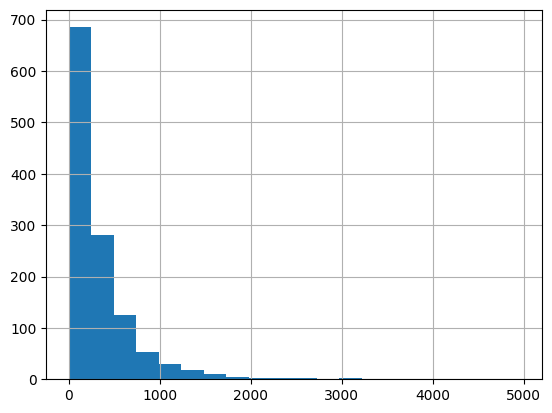

In [82]:
data_y_train[(data_x_train["IS_SEPSIS"]==1) ]['total_stay'].hist(bins=20)

In [83]:
(data_y_train['total_stay']>30*24).sum()/0.8

1595.0

In [84]:

# trying to do scaling from here
train_categorical = pd.DataFrame(data_x_train[["GENDER_NUM","IS_SEPSIS"]]).reset_index(drop=True)
test_categorical = pd.DataFrame(data_x_test[["GENDER_NUM","IS_SEPSIS"]]).reset_index(drop=True)

scaler = StandardScaler()
scaled_x_train = scaler.fit_transform(data_x_train.drop(["GENDER_NUM","IS_SEPSIS"], axis=1))
scaled_x_train_columns= data_x_train.drop(["GENDER_NUM","IS_SEPSIS"], axis=1).columns

scaled_x_test = scaler.transform(data_x_test.drop(["GENDER_NUM","IS_SEPSIS"], axis=1))
scaled_x_test_columns= data_x_test.drop(["GENDER_NUM","IS_SEPSIS"], axis=1).columns

data_x_train = pd.DataFrame(scaled_x_train, columns=scaled_x_train_columns)
data_x_test = pd.DataFrame(scaled_x_test, columns=scaled_x_test_columns)

data_x_train = pd.concat([data_x_train, train_categorical], axis=1)

data_x_test = pd.concat([data_x_test, test_categorical], axis=1)


In [85]:
data_x_train = data_x_train.drop(["IS_SEPSIS"], axis = 1)

test_sepsis = data_x_test["IS_SEPSIS"]    # labesls of sepsis of test data
data_x_test = data_x_test.drop("IS_SEPSIS", axis = 1)

In [86]:
data_y_train

,status,total_stay
13988,False,25.0
21924,False,332.0
44517,False,85.0
7721,False,173.0
2567,False,141.0
...,...,...
21127,False,138.0
8873,False,335.0
44697,False,94.0
37804,False,231.0


In [87]:
#data_y = df_required[["status","total_stay"]].to_numpy()
#data_y = df_required[["status","total_stay"]].to_records(index=False)
#np.array(data_y)
data_y_train = data_y_train.to_records(index=False)
data_y_test = data_y_test.to_records(index=False)
data_y_train

rec.array([(False,  25.), (False, 332.), (False,  85.), ...,
           (False,  94.), (False, 231.), ( True, 562.)],
          dtype=[('status', '?'), ('total_stay', '<f8')])

In [32]:
#data_x = df_required.drop(["status","total_stay","SUBJECT_ID","HADM_ID","IS_SEPSIS"], axis = 1)

In [33]:
data_y_train.dtype

dtype((numpy.record, [('status', '?'), ('total_stay', '<f8')]))

In [34]:
set_config(display="text")  # displays text representation of estimators

estimator = CoxPHSurvivalAnalysis()
estimator.fit(data_x_train, data_y_train)

CoxPHSurvivalAnalysis()

In [35]:
pd.Series(estimator.coef_, index=data_x_train.columns)

AGE             0.407718
ITEMID_50804   -7.204566
ITEMID_50809   -0.024072
ITEMID_50813    0.145049
ITEMID_50818    6.792321
ITEMID_50820    0.092192
ITEMID_50821    0.561696
ITEMID_50861   -0.062319
ITEMID_50862    0.003611
ITEMID_50863    0.144252
ITEMID_50878    0.082646
ITEMID_50882   -0.305196
ITEMID_50885   -0.108193
ITEMID_50893   -0.048608
ITEMID_50902   -0.114101
ITEMID_50910   -0.037422
ITEMID_50912   -0.022497
ITEMID_50931    0.141660
ITEMID_50954    0.042584
ITEMID_50960   -0.042018
ITEMID_50970    0.170689
ITEMID_50971    0.039612
ITEMID_50983    0.236285
ITEMID_51003    0.077160
ITEMID_51006    0.212663
ITEMID_51144    0.206071
ITEMID_51221   -0.219887
ITEMID_51222   -0.140096
ITEMID_51237   -0.572756
ITEMID_51244   -0.961825
ITEMID_51248   -6.671432
ITEMID_51249    0.172541
ITEMID_51250    6.612411
ITEMID_51256    0.976397
ITEMID_51265   -0.130732
ITEMID_51274    0.535578
ITEMID_51275    0.050989
ITEMID_51277    0.182216
ITEMID_51279   -0.115969
ITEMID_51301    0.327438


In [36]:
#pred_surv = estimator.predict_survival_function(data_x_test[:25])
pred_surv = estimator.predict_survival_function(data_x_test[2400:2500])


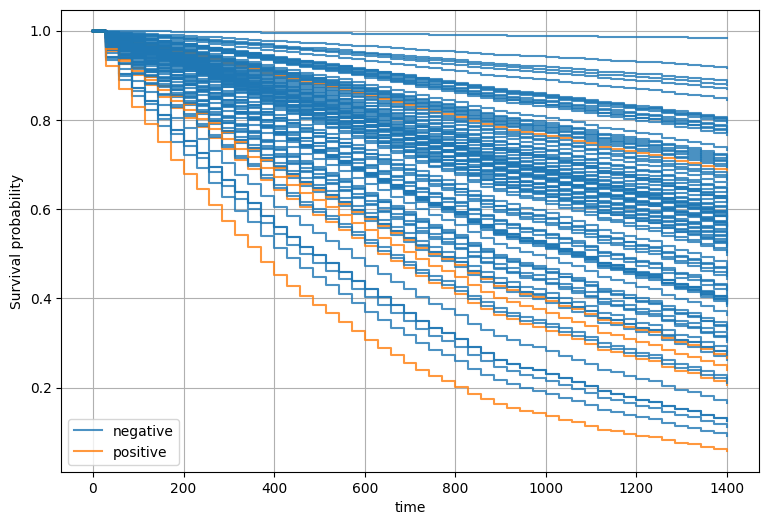

In [109]:
#surv_fns = coxnet_pred.predict_survival_function(data_x_test[100:200])

#time_points = np.quantile(data_y_test["total_stay"], np.linspace(0, 0.99, 100))

time_points =  np.linspace(0, 1400)
legend_handles = []
legend_labels = []
_, ax = plt.subplots(figsize=(9, 6))
for fn, label in zip(pred_surv, test_sepsis[2400:2500]):
    (line,) = ax.step(time_points, fn(time_points), where="post", color=f"C{label}", alpha=0.8)
    if len(legend_handles) <= label:
        name = "positive" if label == 1 else "negative"
        legend_labels.append(name)
        legend_handles.append(line)

ax.legend(legend_handles, legend_labels)
ax.set_xlabel("time")
ax.set_ylabel("Survival probability")
ax.grid(True)

In [110]:
legend_labels

['negative', 'positive']

In [37]:
from sksurv.metrics import concordance_index_censored

prediction = estimator.predict(data_x_test)
result = concordance_index_censored(data_y_test["status"], data_y_test["total_stay"], prediction)
result[0]

0.7347534135473464

In [38]:
# Concordance index score
print(estimator.score(data_x_test, data_y_test))

0.7347534135473464


In [113]:
# which single variable is best risk predictor
def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j : j + 1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores


scores = fit_and_score_features(data_x_train.values, data_y_train)
pd.Series(scores, index=data_x_train.columns).sort_values(ascending=False)

ITEMID_50813    0.647396
ITEMID_51006    0.616709
ITEMID_50821    0.606556
ITEMID_51274    0.604541
ITEMID_51237    0.603569
ITEMID_50818    0.602899
ITEMID_51301    0.601164
ITEMID_51144    0.599051
AGE             0.597097
ITEMID_50912    0.596323
ITEMID_51277    0.589284
ITEMID_50820    0.586666
ITEMID_50970    0.585713
ITEMID_50804    0.584877
ITEMID_51275    0.580894
ITEMID_51250    0.580086
ITEMID_50931    0.577400
ITEMID_50910    0.576520
ITEMID_51003    0.574253
ITEMID_50878    0.562958
ITEMID_51256    0.561088
ITEMID_50960    0.560599
sofa_score      0.557148
ITEMID_50809    0.552998
ITEMID_50861    0.551393
ITEMID_50885    0.549957
ITEMID_50863    0.547745
ITEMID_51265    0.543062
ITEMID_50971    0.541509
ITEMID_50954    0.534709
ITEMID_50983    0.522819
GENDER_NUM      0.522496
ITEMID_50893    0.522348
ITEMID_51248    0.520260
ITEMID_50902    0.514112
ITEMID_51493    0.512449
ITEMID_50862    0.505520
ITEMID_51221    0.487677
ITEMID_51244    0.485398
ITEMID_51222    0.467462


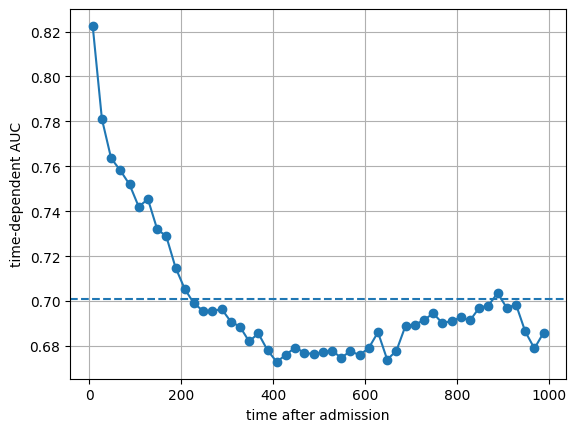

In [39]:
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)
va_times = np.arange(8, 1000, 20)
cph_risk_scores = estimator.predict(data_x_test)
cph_auc, cph_mean_auc = cumulative_dynamic_auc(data_y_train, data_y_test, cph_risk_scores, va_times)

plt.plot(va_times, cph_auc, marker="o")
plt.axhline(cph_mean_auc, linestyle="--")
plt.xlabel("time after admission")
plt.ylabel("time-dependent AUC")
plt.grid(True)

In [115]:


pipe = Pipeline(
    [
        ("encode", OneHotEncoder()),
        ("select", SelectKBest(fit_and_score_features, k=3)),
        ("model", CoxPHSurvivalAnalysis()),
    ]
)

In [116]:
"""
from sklearn.model_selection import GridSearchCV, KFold

#param_grid = {"select__k": np.arange(1, data_x_train.shape[1] + 1)}
param_grid = {"select__k": np.arange(15, 19 + 1)}
cv = KFold(n_splits=3, random_state=1, shuffle=True)
gcv = GridSearchCV(pipe, param_grid, return_train_score=True, cv=cv)
gcv.fit(data_x_train, data_y_train)

results = pd.DataFrame(gcv.cv_results_).sort_values(by="mean_test_score", ascending=False)
results.loc[:, ~results.columns.str.endswith("_time")]

"""

'\nfrom sklearn.model_selection import GridSearchCV, KFold\n\n#param_grid = {"select__k": np.arange(1, data_x_train.shape[1] + 1)}\nparam_grid = {"select__k": np.arange(15, 19 + 1)}\ncv = KFold(n_splits=3, random_state=1, shuffle=True)\ngcv = GridSearchCV(pipe, param_grid, return_train_score=True, cv=cv)\ngcv.fit(data_x_train, data_y_train)\n\nresults = pd.DataFrame(gcv.cv_results_).sort_values(by="mean_test_score", ascending=False)\nresults.loc[:, ~results.columns.str.endswith("_time")]\n\n'

In [40]:
Xt = data_x_train.copy()
y = data_y_train.copy()

# Penalized cox

In [41]:
import warnings
from sklearn.exceptions import FitFailedWarning
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis

coxnet_pipe = make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.8, alpha_min_ratio=0.001, max_iter=100))
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FitFailedWarning)
coxnet_pipe.fit(Xt, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alpha_min_ratio=0.001, l1_ratio=0.8,
                                        max_iter=100))])

In [42]:
estimated_alphas = coxnet_pipe.named_steps["coxnetsurvivalanalysis"].alphas_
cv = KFold(n_splits=5, shuffle=True, random_state=0)
gcv = GridSearchCV(
    make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9)),
    param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in estimated_alphas]},
    cv=cv,
    error_score=0.5,
    n_jobs=1,
).fit(Xt, y)

cv_results = pd.DataFrame(gcv.cv_results_)

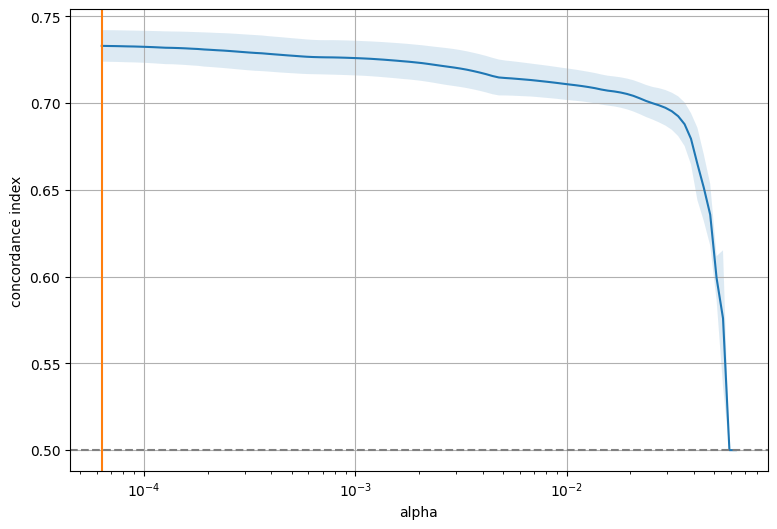

In [43]:
alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=0.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(gcv.best_params_["coxnetsurvivalanalysis__alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True) 

Number of non-zero coefficients: 41


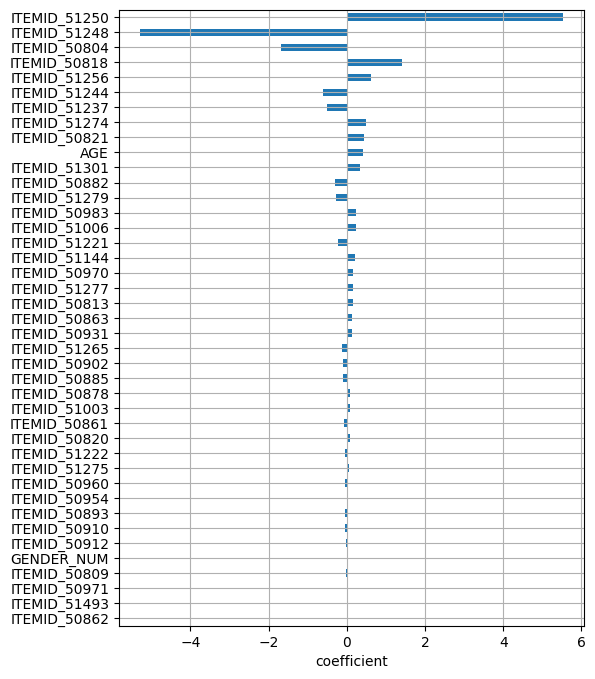

In [44]:
best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]

best_coefs = pd.DataFrame(best_model.coef_, index=Xt.columns, columns=["coefficient"])

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print(f"Number of non-zero coefficients: {non_zero}")

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

In [45]:
coxnet_pred = make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9, fit_baseline_model=True))
coxnet_pred.set_params(**gcv.best_params_)
coxnet_pred.fit(Xt, y)
coxnet_pred.score(data_x_test,data_y_test)

0.7340526785363345

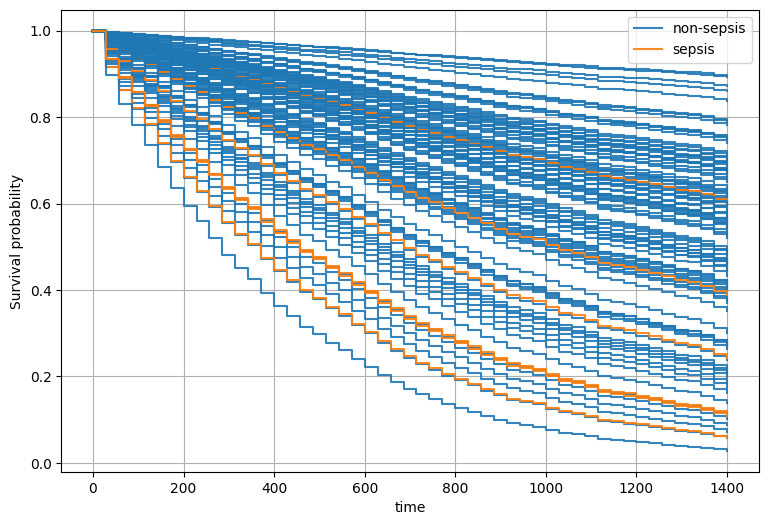

In [57]:
surv_fns = coxnet_pred.predict_survival_function(data_x_test[2400:2500])

time_points =  np.linspace(0, 1400)
#time_points = np.quantile(y["total_stay"], np.linspace(0, 0.6, 100))
legend_handles = []
legend_labels = []
_, ax = plt.subplots(figsize=(9, 6))
for fn, label in zip(surv_fns, test_sepsis[2400:2500]):
    (line,) = ax.step(time_points, fn(time_points), where="post", color=f"C{label}", alpha=0.9)
    
    if len(legend_handles) <= label:
        name = "sepsis" if label == 1 else "non-sepsis"
        legend_labels.append(name)
        legend_handles.append(line)

ax.legend(legend_handles, legend_labels)
ax.set_xlabel("time")
ax.set_ylabel("Survival probability")
ax.grid(True)



In [ ]:
va_times = np.arange(8, 1000, 20)
coxnet_risk_scores = coxnet_pred.predict(data_x_test)
cph_auc, cph_mean_auc = cumulative_dynamic_auc(data_y_train, data_y_test, coxnet_risk_scores, va_times)

plt.plot(va_times, cph_auc, marker="o")
plt.axhline(cph_mean_auc, linestyle="--")
plt.xlabel("time after admission")
plt.ylabel("time-dependent AUC")
plt.grid(True)

### elastic net penalty

In [46]:
cox_elastic_net = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.001)
cox_elastic_net.fit(Xt, y)

CoxnetSurvivalAnalysis(alpha_min_ratio=0.001, l1_ratio=0.9)

In [60]:
def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(9, 6))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(alpha_min, coef, name + "   ", horizontalalignment="right", verticalalignment="center")
        
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")

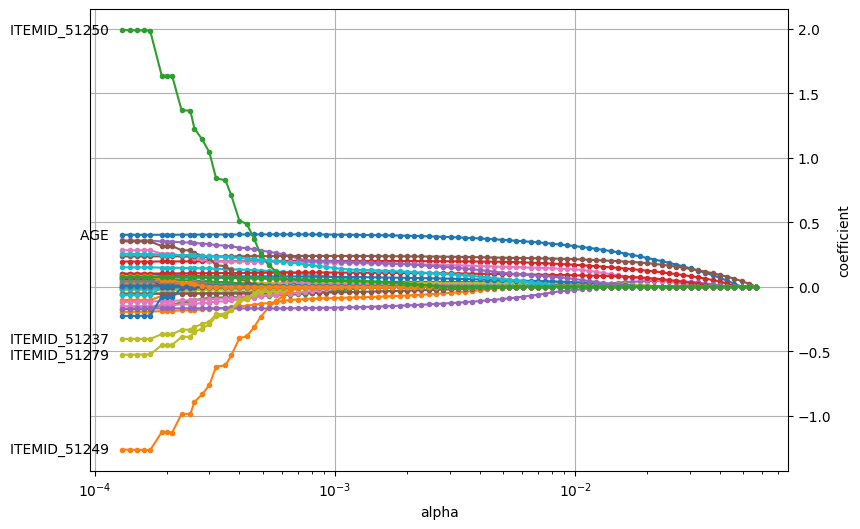

In [61]:
coefficients_elastic_net = pd.DataFrame(
    cox_elastic_net.coef_, index=Xt.columns, columns=np.round(cox_elastic_net.alphas_,5)
)

plot_coefficients(coefficients_elastic_net, n_highlight=5)

In [47]:
surv_fns = coxnet_pred.predict(data_x_test)
result = concordance_index_censored(data_y_test["status"], data_y_test["total_stay"], surv_fns)
result[0]

0.7340526785363345

## Random forest survival

In [88]:

# Compute sample weights based on class imbalance
sample_weights = compute_sample_weight(class_weight='balanced', y=[ix[0]*1 for ix in data_y_train])


In [89]:
y

rec.array([(False,  25.), (False, 332.), (False,  85.), ...,
           (False,  94.), (False, 231.), ( True, 562.)],
          dtype=[('status', '?'), ('total_stay', '<f8')])

In [93]:
rsf_gbsg = RandomSurvivalForest(n_estimators=100, min_samples_split=5, min_samples_leaf=5, n_jobs=-1, random_state=1)
rsf_gbsg.fit(data_x_train, data_y_train,sample_weight=sample_weights)


RandomSurvivalForest(min_samples_leaf=15, min_samples_split=10, n_jobs=-1,
                     random_state=1)

In [94]:
# Concordance index score
rsf_gbsg.score(data_x_test, data_y_test)

0.783341440952932

In [66]:
'''
for i in range(9,10):
  rsf_gbsg = RandomSurvivalForest(n_estimators=100,min_samples_split=5, min_samples_leaf=5, n_jobs=-1, random_state=1)
  rsf_gbsg.fit(data_x_train, data_y_train,sample_weight=sample_weights)
  print(i,rsf_gbsg.score(data_x_test, data_y_test))
  '''

9 0.7852063343401997


In [67]:
rsf_gbsg.get_params(deep=True)

{'bootstrap': True,
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_samples_leaf': 15,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

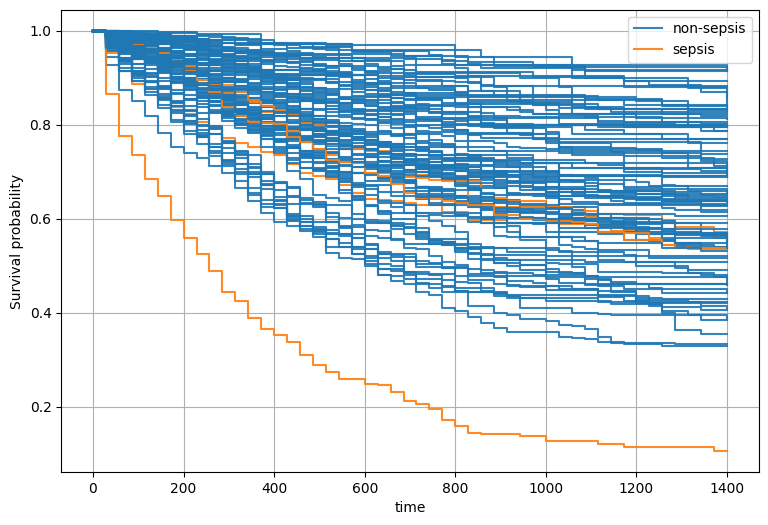

In [52]:
surv_fns = rsf_gbsg.predict_survival_function(data_x_test[2400:2500])

time_points =  np.linspace(0, 1400)
#time_points = np.quantile(y["total_stay"], np.linspace(0, 0.6, 100))
legend_handles = []
legend_labels = []
_, ax = plt.subplots(figsize=(9, 6))
for fn, label in zip(surv_fns, test_sepsis[2400:2500]):
    (line,) = ax.step(time_points, fn(time_points), where="post", color=f"C{label}", alpha=0.9)
    
    if len(legend_handles) <= label:
        name = "sepsis" if label == 1 else "non-sepsis"
        legend_labels.append(name)
        legend_handles.append(line)

ax.legend(legend_handles, legend_labels)
ax.set_xlabel("time")
ax.set_ylabel("Survival probability")
ax.grid(True)

## GBM Survival

In [86]:

# fitting the gbm model on cph likelihood with regression trees as base learners
est_cph_tree = GradientBoostingSurvivalAnalysis(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
est_cph_tree.fit(data_x_train, data_y_train)
c_index = est_cph_tree.score(data_x_test,data_y_test)
print(round(c_index, 3))

0.74


In [87]:

# c_index score
round(est_cph_tree.score(data_x_test,data_y_test),3)


0.74

In [82]:
'''
# lets see how the test performance changes with the ensemble size (n_estimators)
scores_cph_tree = {}

est_cph_tree = GradientBoostingSurvivalAnalysis(learning_rate=1.0, max_depth=1, random_state=0)
for i in range(10, 11):
    n_estimators = i * 5
    est_cph_tree.set_params(n_estimators=n_estimators)
    est_cph_tree.fit(data_x_train, data_y_train)
    scores_cph_tree[n_estimators] = est_cph_tree.score(data_x_test, data_y_test)


x, y = zip(*scores_cph_tree.items())
plt.plot(x, y)
plt.xlabel("n_estimator")
plt.ylabel("concordance index")
plt.grid(True)

'''

'\n# lets see how the test performance changes with the ensemble size (n_estimators)\nscores_cph_tree = {}\n\nest_cph_tree = GradientBoostingSurvivalAnalysis(learning_rate=1.0, max_depth=1, random_state=0)\nfor i in range(10, 11):\n    n_estimators = i * 5\n    est_cph_tree.set_params(n_estimators=n_estimators)\n    est_cph_tree.fit(data_x_train, data_y_train)\n    scores_cph_tree[n_estimators] = est_cph_tree.score(data_x_test, data_y_test)\n\n\nx, y = zip(*scores_cph_tree.items())\nplt.plot(x, y)\nplt.xlabel("n_estimator")\nplt.ylabel("concordance index")\nplt.grid(True)\n\n'

In [83]:
'''
class EarlyStoppingMonitor:
    def __init__(self, window_size, max_iter_without_improvement):
        self.window_size = window_size
        self.max_iter_without_improvement = max_iter_without_improvement
        self._best_step = -1

    def __call__(self, iteration, estimator, args):
        # continue training for first self.window_size iterations
        if iteration < self.window_size:
            return False

        # compute average improvement in last self.window_size iterations.
        # oob_improvement_ is the different in negative log partial likelihood
        # between the previous and current iteration.
        start = iteration - self.window_size + 1
        end = iteration + 1
        improvement = np.mean(estimator.oob_improvement_[start:end])

        if improvement > 1e-6:
            self._best_step = iteration
            return False  # continue fitting

        # stop fitting if there was no improvement
        # in last max_iter_without_improvement iterations
        diff = iteration - self._best_step
        return diff >= self.max_iter_without_improvement


est_early_stopping = GradientBoostingSurvivalAnalysis(
    n_estimators=120, learning_rate=0.9, subsample=0.7, max_depth=1, random_state=0
)

monitor = EarlyStoppingMonitor(25, 50)

est_early_stopping.fit(data_x_train, data_y_train, monitor=monitor)

print("Fitted base learners:", est_early_stopping.n_estimators_)

cindex = est_early_stopping.score(data_x_test, data_y_test)
print("Performance on test set", round(cindex, 3))
'''

'\nclass EarlyStoppingMonitor:\n    def __init__(self, window_size, max_iter_without_improvement):\n        self.window_size = window_size\n        self.max_iter_without_improvement = max_iter_without_improvement\n        self._best_step = -1\n\n    def __call__(self, iteration, estimator, args):\n        # continue training for first self.window_size iterations\n        if iteration < self.window_size:\n            return False\n\n        # compute average improvement in last self.window_size iterations.\n        # oob_improvement_ is the different in negative log partial likelihood\n        # between the previous and current iteration.\n        start = iteration - self.window_size + 1\n        end = iteration + 1\n        improvement = np.mean(estimator.oob_improvement_[start:end])\n\n        if improvement > 1e-6:\n            self._best_step = iteration\n            return False  # continue fitting\n\n        # stop fitting if there was no improvement\n        # in last max_iter_wi

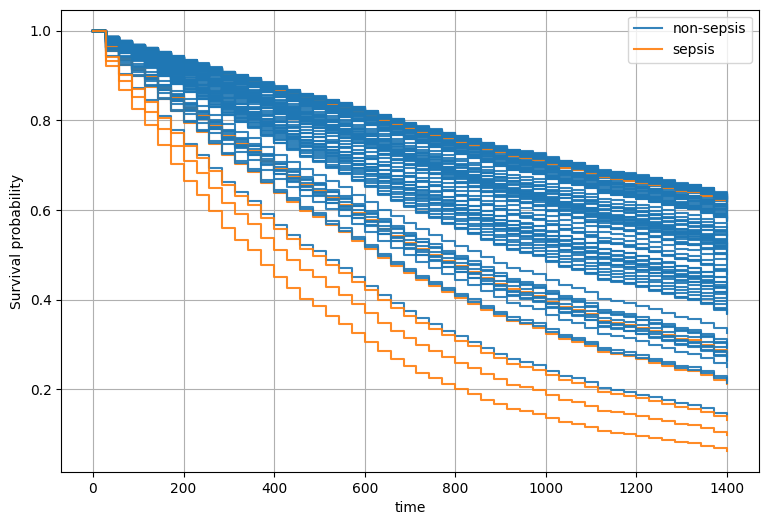

In [97]:


surv_fns = est_cph_tree.predict_survival_function(data_x_test[2400:2500])

time_points =  np.linspace(0, 1400)
#time_points = np.quantile(y["total_stay"], np.linspace(0, 0.6, 100))
legend_handles = []
legend_labels = []
_, ax = plt.subplots(figsize=(9, 6))
for fn, label in zip(surv_fns, test_sepsis[2400:2500]):
    (line,) = ax.step(time_points, fn(time_points), where="post", color=f"C{label}", alpha=0.9)
    
    if len(legend_handles) <= label:
        name = "sepsis" if label == 1 else "non-sepsis"
        legend_labels.append(name)
        legend_handles.append(line)

ax.legend(legend_handles, legend_labels)
ax.set_xlabel("time")
ax.set_ylabel("Survival probability")
ax.grid(True)

# Comparison of models

In [89]:

score_cindex = pd.Series(
    [
        est_cph_tree.score(data_x_test,data_y_test),
        rsf_gbsg.score(data_x_test, data_y_test),
        coxnet_pred.score(data_x_test, data_y_test),
        estimator.score(data_x_test, data_y_test),
        0.5,
    ],
    index=["GBM","RSF", "Coxnet","cph", "Random"],
    name="c-index",
)

score_cindex.round(3)

GBM       0.740
RSF       0.771
Coxnet    0.717
cph       0.729
Random    0.500
Name: c-index, dtype: float64

In [91]:
lower, upper = np.percentile(df_required["total_stay"], [10, 90])
gbsg_times = np.arange(lower, upper + 1)

In [92]:

gbm_surv_prob = np.row_stack([fn(gbsg_times) for fn in est_cph_tree.predict_survival_function(data_x_test)])
rsf_surv_prob = np.row_stack([fn(gbsg_times) for fn in rsf_gbsg.predict_survival_function(data_x_test)])
coxnet_surv_prob = np.row_stack([fn(gbsg_times) for fn in coxnet_pred.predict_survival_function(data_x_test)])
cph_surv_prob = np.row_stack([fn(gbsg_times) for fn in estimator.predict_survival_function(data_x_test)])

In [94]:
random_surv_prob = 0.5 * np.ones((data_y_test.shape[0], gbsg_times.shape[0]))

score_brier = pd.Series(
    [
        integrated_brier_score(df_required[["status","total_stay"]].to_records(index=False), data_y_test, prob, gbsg_times)
        for prob in (gbm_surv_prob,rsf_surv_prob, coxnet_surv_prob, cph_surv_prob, random_surv_prob)
    ],
    index=["GBM","RSF", "Coxnet", "cph", "Random"],
    name="IBS",
)

pd.concat((score_cindex, score_brier), axis=1).round(3)

,c-index,IBS
GBM,0.740,0.108
RSF,0.771,0.104
Coxnet,0.717,0.111
cph,0.729,0.110
Random,0.500,0.249


In [ ]:
rsf_gbsg.score(data_x_test, data_y_test)

0.7289329863903297